# Library

In [1]:
import pandas as pd
import numpy as np
from scipy import interpolate
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_log_error

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

from pandas.tseries.offsets import MonthEnd
import matplotlib.dates as mdates

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
# Dataset that will be used
train = pd.read_csv('../input/bri-data-hackathon-cr-optimization/train.csv', index_col=[0], parse_dates=[0])
test = pd.read_csv('../input/bri-data-hackathon-cr-optimization/test.csv')
desc = pd.read_csv('../input/bri-data-hackathon-cr-optimization/data_description.csv')
sample = pd.read_csv('../input/bri-data-hackathon-cr-optimization/sample_submission.csv')

desc

,variabel,sample Data,Deskripsi
0,cash_in_echannel,7.924471e+09,Total Kas Masuk pada kas eChannel (ATM dan CRM)
1,cash_out_echannel,7.924471e+09,Total Kas keluar pada kas eChannel (ATM dan CRM)
2,cash_in_kantor,1.372300e+10,Total kas masuk pada kas kantor
3,cash_out_kantor,-2.767644e+10,Total kas keluar pada kas kantor
4,cr_ketetapan_total_bkn_sum,4.350000e+00,Maksimum cash ratio yang dii tetapkan kantor p...
5,giro,5.355247e+10,Total simpanan giro
6,deposito,1.344615e+10,Total simpanan deposito
7,kewajiban_lain,3.490872e+09,"Simpanan selain giro tabungan dan deposito ,sa..."
8,tabungan,1.659893e+11,Total simpanan tabungan
9,rata_dpk_mingguan,2.401906e+11,rata - rata saldo DPK mingguan


# Basic Preprocessing

In [3]:
# missing dates
start = train.index[0]
end = train.index[-1]
ll = pd.date_range(start, end).tolist()
missing = [(i,j) for i,j in enumerate(ll) if j not in train.index]
missing

[(325, Timestamp('2020-06-20 00:00:00', freq='D')),
 (329, Timestamp('2020-06-24 00:00:00', freq='D')),
 (393, Timestamp('2020-08-27 00:00:00', freq='D'))]

In [4]:
# data imputation
for d in missing:
    # get middle value between 2 data
    tmp = (train.iloc[d[0]] + train.iloc[d[0]-1]) / 2
    # give timestamp for the index
    tmp.name = d[1]
    # append new data into the dataframe
    train = train.append(tmp)
train.sort_index(inplace=True)

In [5]:
# How much missing values that the data have
train.isna().sum()

cash_in_echannel              0
cash_out_echannel             0
cash_in_kantor                0
cash_out_kantor               0
cr_ketetapan_total_bkn_sum    0
giro                          0
deposito                      0
kewajiban_lain                0
tabungan                      0
rata_dpk_mingguan             0
kas_kantor                    0
kas_echannel                  0
dtype: int64

In [6]:
# Date shifting because the data is record one day early 
start = train.index[0] + timedelta(1)
end = train.index[-1] + timedelta(1)
train.index = pd.date_range(start, end)

# Build Model 

## PROPHET

In [7]:
from fbprophet import Prophet
from fbprophet import hdays
from fbprophet.diagnostics import cross_validation

import seaborn as sns

import logging
logging.getLogger().setLevel(logging.ERROR)

### Preparing dataset into prophet format

In [8]:
# Transform to prophet dataset format
train_prophet = pd.DataFrame()
train_prophet['y_cash_in_kantor'] = train['cash_in_kantor']
train_prophet['y_cash_out_kantor'] = train['cash_out_kantor']
train_prophet['y_cash_in_echannel'] = train['cash_in_echannel']
train_prophet['y_cash_out_echannel'] = train['cash_out_echannel']
train_prophet['kas_kantor'] = train['kas_kantor']
train_prophet['kas_echannel'] = train['kas_echannel']
train_prophet = train_prophet.reset_index().rename(columns= {'index':'ds'})
train_prophet.head()

,ds,y_cash_in_kantor,y_cash_out_kantor,y_cash_in_echannel,y_cash_out_echannel,kas_kantor,kas_echannel
0,2019-08-01,1.436722e+11,-1.106104e+11,7.303000e+08,-1.304400e+09,1.928940e+09,2.939100e+09
1,2019-08-02,3.144131e+11,-6.710987e+10,7.322000e+08,-8.321500e+08,2.492322e+11,2.839150e+09
2,2019-08-03,1.251294e+09,-1.142332e+09,1.169800e+09,-6.214000e+08,2.493411e+11,3.387550e+09
3,2019-08-04,0.000000e+00,0.000000e+00,9.134500e+08,-4.240500e+08,2.493411e+11,3.876950e+09
4,2019-08-05,9.883331e+10,-8.729274e+10,7.752500e+08,-7.779500e+08,2.608817e+11,3.874250e+09


### Holidays Effect in Prophet

In [9]:
holidays_indo = hdays.Indonesia()
holidays_indo._populate(2019)
holidays_indo._populate(2020)
holiday = pd.DataFrame([holidays_indo], index=['holiday']).T.rename_axis('ds').reset_index()
holiday

,ds,holiday
0,2019-01-01,New Year's Day
1,2019-02-05,Chinese New Year
2,2019-03-07,Day of Silence/ Nyepi
3,2019-04-03,Ascension of the Prophet
4,2019-05-01,Labor Day
5,2019-05-30,Ascension of Jesus
6,2019-05-19,Buddha's Birthday
7,2019-06-01,Pancasila Day
8,2019-06-06,Eid al-Fitr
9,2019-08-17,Independence Day


### Prophet Validations : kas_kantor and kas_echannel directly prediction

kas_kantor


  0%|          | 0/2 [00:00<?, ?it/s]

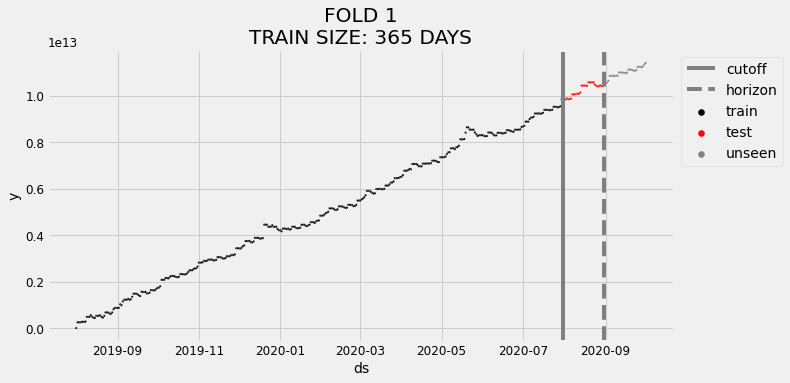

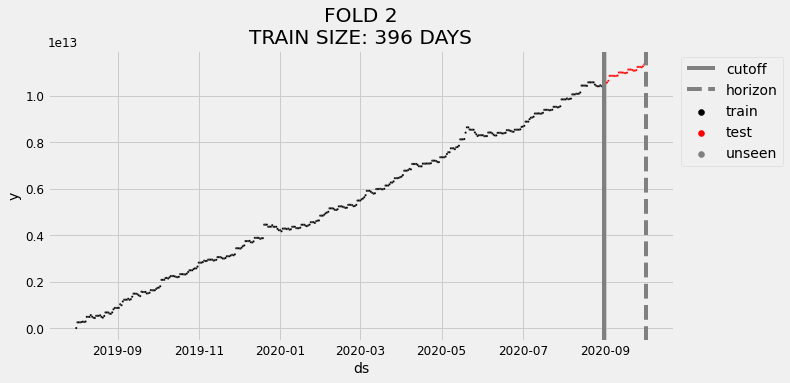

Mean 0.011583703951174685
Std rmsle 0.0057325833460761194
kas_echannel


  0%|          | 0/2 [00:00<?, ?it/s]

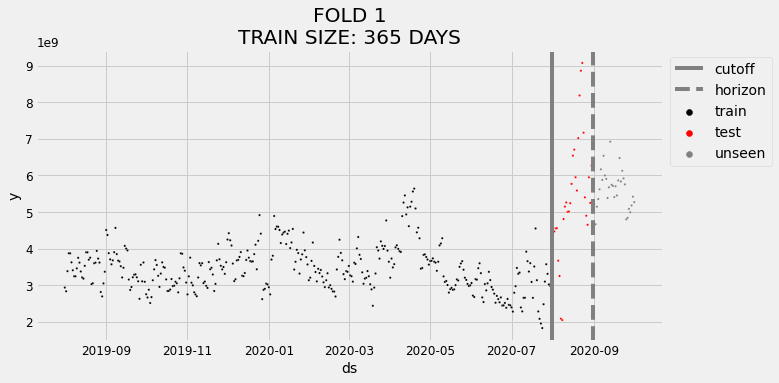

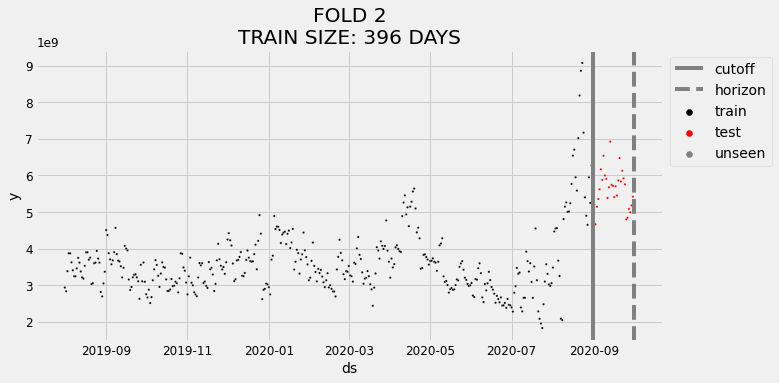

Mean 0.5038381475981452
Std rmsle 0.059984913962320335


In [10]:
prediction_size = 31
result = pd.DataFrame()
for item in ['kas_kantor','kas_echannel']:
    print(item)
    data = train_prophet[['ds',item]].copy()
    data.columns = ['ds','y']
    m = Prophet(n_changepoints=25, # default = 25
                changepoint_range=0.95, # default = 0.8
                changepoint_prior_scale=0.5, # default = 0.05
                weekly_seasonality = 10,
                holidays = holiday)
    
    m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
    m.fit(data) 
    
    # Create validation set
    df_cv = cross_validation(m, initial='360 days', horizon='31 days', period='31 days')
    df_copy = data[['ds', 'y']].copy()
    df_cutoff_horizon = df_cv.groupby('cutoff')[['ds']].max()

    for i, (cutoff, horizon) in enumerate(df_cutoff_horizon.iterrows()):
        horizon_cutoff = horizon['ds']

        df_copy['type'] = df_copy['ds'].apply(
                          lambda date: 'train' if date < cutoff else 
                          'test' if date < horizon_cutoff else 'unseen')

        plt.figure(figsize=(10, 5))
        sns.scatterplot(x='ds', y='y', hue='type', s=5,
                      palette=['black', 'red', 'gray'],
                      data=df_copy)
        plt.axvline(x=cutoff, color='gray', label='cutoff')
        plt.axvline(x=horizon_cutoff, color='gray', ls='--', label='horizon')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
        plt.title(f"FOLD {i+1}\nTRAIN SIZE: {df_copy['type'].value_counts()['train']} DAYS")
        plt.show()
        
    cv_rmsle = df_cv.groupby('cutoff').apply(
    lambda x: mean_squared_log_error(y_true=x['y'],
                                     y_pred=x['yhat']) ** 0.5)
    print('Mean',cv_rmsle.mean())
    print('Std rmsle',np.std(cv_rmsle))

### Prophet Hyperparameter Tuning

In [11]:
from tqdm import tqdm
import itertools

# Grid search parameters (TO DO: specify possible values)
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1,0.5],
    'changepoint_range': [0.8, 0.90,0.95],
    'weekly_seasonality' : [5,7,10,14]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

for item in ['kas_kantor','kas_echannel']:
    data = train_prophet[['ds',item]].copy()
    data.columns = ['ds','y']
    
    rmsles = []  # Store the RMSLEs for each params here

    # Use cross validation to evaluate all parameters
    for params in tqdm(all_params):
        # fitting model
        # (TO DO: change the data and add other components: seasonality, holiday, regressor)
        model = Prophet(**params,
                      holidays=holiday)
        model.fit(data)

        # Expanding window cross validation (TO DO: use different values)
        cv = cross_validation(model, initial='360 days', period='31 days', horizon='31 days',
                            parallel='processes')

        # Evaluation metrics: RMSLE
        rmsle = cv.groupby('cutoff').apply(
          lambda x: mean_squared_log_error(y_true=x['y'],
                                           y_pred=x['yhat']) ** 0.5)

        mean_rmsle = rmsle.mean()
        rmsles.append(mean_rmsle)
        
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmsle'] = rmsles
    tuning_results.sort_values(by='rmsle')

    best_params = all_params[np.argmin(rmsles)]
    print(item,best_params)

  0%|          | 0/48 [00:00<?, ?it/s]

kas_kantor {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'weekly_seasonality': 5}


100%|██████████| 48/48 [02:46<00:00,  3.48s/it]

kas_echannel {'changepoint_prior_scale': 0.001, 'changepoint_range': 0.8, 'weekly_seasonality': 7}


In [12]:
best_params_kantor = {'changepoint_prior_scale': 0.1, 'changepoint_range': 0.95, 'weekly_seasonality': 5}
best_params_echannel = {'changepoint_prior_scale': 0.001,'changepoint_range': 0.8,'weekly_seasonality': 7}

kas_kantor


  0%|          | 0/2 [00:00<?, ?it/s]

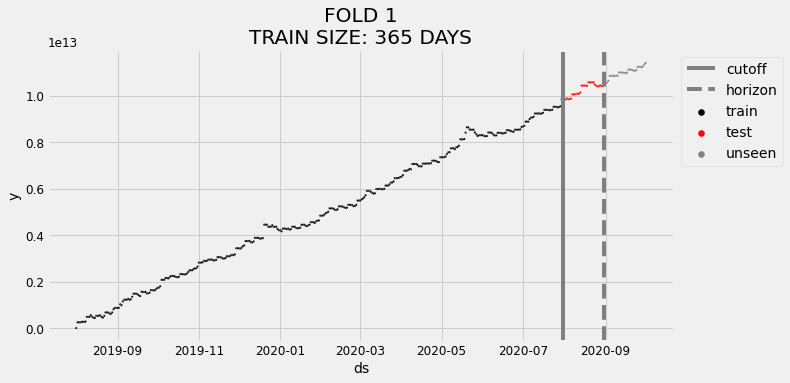

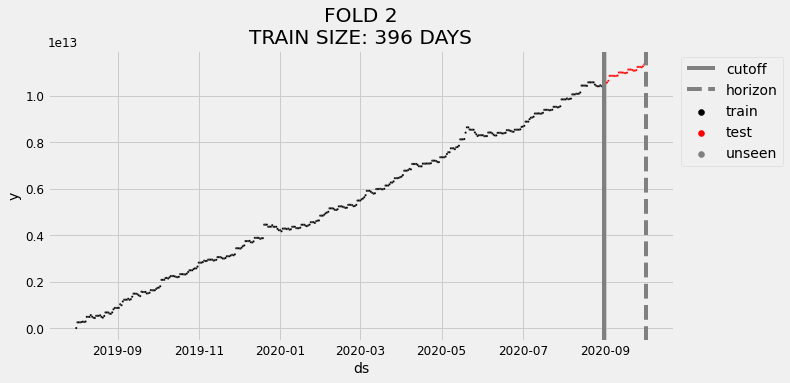

Mean 0.011291017673038256
Std rmsle 0.002882909524563576
kas_echannel


  0%|          | 0/2 [00:00<?, ?it/s]

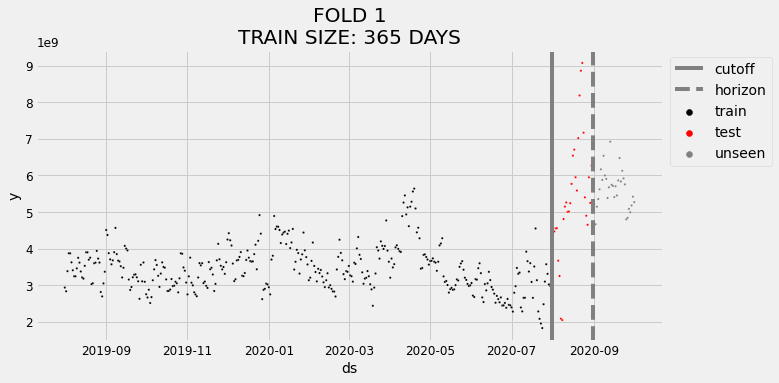

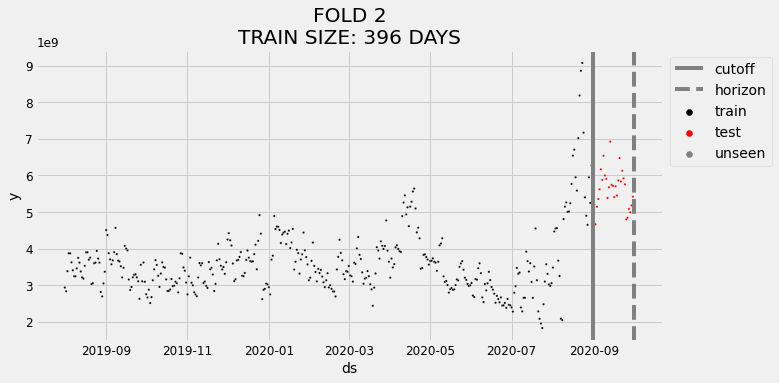

Mean 0.4159632399448268
Std rmsle 0.05934641777509558


In [13]:
for item,best_params in zip(['kas_kantor','kas_echannel'],[best_params_kantor,best_params_echannel]):
    print(item)
    
    data = train_prophet[['ds',item]].copy()
    data.columns = ['ds','y']
    m = Prophet(**best_params,
                holidays = holiday)
    
    m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
    m.fit(data) 
    
    # Create validation set
    df_cv = cross_validation(m, initial='360 days', horizon='31 days', period='31 days')
    df_copy = data[['ds', 'y']].copy()
    df_cutoff_horizon = df_cv.groupby('cutoff')[['ds']].max()

    for i, (cutoff, horizon) in enumerate(df_cutoff_horizon.iterrows()):
        horizon_cutoff = horizon['ds']

        df_copy['type'] = df_copy['ds'].apply(
                          lambda date: 'train' if date < cutoff else 
                          'test' if date < horizon_cutoff else 'unseen')

        plt.figure(figsize=(10, 5))
        sns.scatterplot(x='ds', y='y', hue='type', s=5,
                      palette=['black', 'red', 'gray'],
                      data=df_copy)
        plt.axvline(x=cutoff, color='gray', label='cutoff')
        plt.axvline(x=horizon_cutoff, color='gray', ls='--', label='horizon')
        plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
        plt.title(f"FOLD {i+1}\nTRAIN SIZE: {df_copy['type'].value_counts()['train']} DAYS")
        plt.show()
        
    cv_rmsle = df_cv.groupby('cutoff').apply(
    lambda x: mean_squared_log_error(y_true=x['y'],
                                     y_pred=x['yhat']) ** 0.5)
    print('Mean',cv_rmsle.mean())
    print('Std rmsle',np.std(cv_rmsle))

### Prophet Validations : Using formulas, predict each cash in and out for each kantor and echannel

In [ ]:
from sklearn.metrics import mean_squared_log_error
# Root mean square logarithmic error
def RMSLE(y_true, y_pred):
    MSLE = mean_squared_log_error(y_true, y_pred)
    return np.sqrt(MSLE)

In [14]:
errors_kantor = []
errors_echannel = []
for month in [7, 8, 9]:
    start = datetime(2020, month, 1)
    end = start + MonthEnd(1)
    
    train_prophet.index = train_prophet['ds']
    
    # Split data
    tra = train_prophet.loc[:start-timedelta(1)]
    val = train_prophet.loc[start:end]
    
    prediction_size = val.shape[0]
    result = pd.DataFrame()
    for item,best_params in zip(['y_cash_in_kantor','y_cash_out_kantor','y_cash_in_echannel','y_cash_out_echannel'],[best_params_kantor,best_params_kantor,best_params_echannel,best_params_echannel]):
        data = train_prophet[['ds',item]].copy()
        data.columns = ['ds','y']
        m = Prophet(**best_params,
                    holidays = holiday)

        m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
        m.fit(data) 
        future = m.make_future_dataframe(periods=prediction_size)
        pred = m.predict(future)
        result[item] = pred['yhat'][len(pred)-prediction_size:]
     
    # Build Prediction for kas_kantor and kas_echannel
    ## Kantor
    result['in_out_kantor'] = result['y_cash_in_kantor'] + result['y_cash_out_kantor']
    nilai_awal = tra['kas_kantor'][-1]

    sub_kantor = []
    for i in result['in_out_kantor'].values:
        nilai_awal = nilai_awal + i
        sub_kantor.append(nilai_awal)
    
    ## eChannel
    result['in_out_echannel'] = result['y_cash_in_echannel'] + result['y_cash_out_echannel']
    nilai_awal = tra['kas_echannel'][-1]

    sub_echannel = []
    for i in result['in_out_echannel'].values:
        nilai_awal = nilai_awal + i
        sub_echannel.append(nilai_awal)
    
    # Evaluation error RMSLE
    err_kantor = RMSLE(val['kas_kantor'], sub_kantor)
    err_echannel = RMSLE(val['kas_echannel'], sub_echannel)
    
    errors_kantor.append(err_kantor)
    errors_echannel.append(err_echannel)
    
print(f'\n Mean RMSLE Kantor: {np.mean(errors_kantor)}')
print(f' Std RMSLE Kantor: {np.std(errors_kantor)}')

print(f'\n Mean RMSLE eChannel: {np.mean(errors_echannel)}')
print(f' Std RMSLE eChannel: {np.std(errors_echannel)}')

NameError: name 'RMSLE' is not defined

In [ ]:
# errors_kantor = []
# errors_echannel = []
# for month in [7, 8, 9]:
#     start = datetime(2020, month, 1)
#     end = start + MonthEnd(1)
    
#     train_prophet.index = train_prophet['ds']
    
#     # Split data
#     tra = train_prophet.loc[:start-timedelta(1)]
#     val = train_prophet.loc[start:end]
    
#     prediction_size = val.shape[0]
#     result = pd.DataFrame()
#     for item in ['y_cash_in_kantor','y_cash_out_kantor','y_cash_in_echannel','y_cash_out_echannel']:
#         # Grid search parameters (TO DO: specify possible values)
#         param_grid = {  
#             'changepoint_prior_scale': [0.001, 0.01, 0.1,0.5],
#             'changepoint_range': [0.8, 0.90,0.95],
#             'weekly_seasonality' : [5,7,10,14]
#         }

#         # Generate all combinations of parameters
#         all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

#         for item in ['kas_kantor','kas_echannel']:
#             data = train_prophet[['ds',item]].copy()
#             data.columns = ['ds','y']

#             rmsles = []  # Store the RMSLEs for each params here

#             # Use cross validation to evaluate all parameters
#             for params in tqdm(all_params):
#                 # fitting model
#                 # (TO DO: change the data and add other components: seasonality, holiday, regressor)
#                 model = Prophet(**params,
#                               holidays=holiday)
#                 model.fit(data)

#                 # Expanding window cross validation (TO DO: use different values)
#                 cv = cross_validation(model, initial='360 days', period='31 days', horizon='31 days',
#                                     parallel='processes')

#                 # Evaluation metrics: RMSLE
#                 rmsle = cv.groupby('cutoff').apply(
#                   lambda x: mean_squared_log_error(y_true=x['y'],
#                                                    y_pred=x['yhat']) ** 0.5)

#                 mean_rmsle = rmsle.mean()
#                 rmsles.append(mean_rmsle)

#             tuning_results = pd.DataFrame(all_params)
#             tuning_results['rmsle'] = rmsles
#             tuning_results.sort_values(by='rmsle')

#             best_params = all_params[np.argmin(rmsles)]
#             print(item,best_params)
#         future = m.make_future_dataframe(periods=prediction_size)
#         pred = m.predict(future)
#         result[item] = pred['yhat'][len(pred)-prediction_size:]
     
#     # Build Prediction for kas_kantor and kas_echannel
#     ## Kantor
#     result['in_out_kantor'] = result['y_cash_in_kantor'] + result['y_cash_out_kantor']
#     nilai_awal = tra['kas_kantor'][-1]

#     sub_kantor = []
#     for i in result['in_out_kantor'].values:
#         nilai_awal = nilai_awal + i
#         sub_kantor.append(nilai_awal)
    
#     ## eChannel
#     result['in_out_echannel'] = result['y_cash_in_echannel'] + result['y_cash_out_echannel']
#     nilai_awal = tra['kas_echannel'][-1]

#     sub_echannel = []
#     for i in result['in_out_echannel'].values:
#         nilai_awal = nilai_awal + i
#         sub_echannel.append(nilai_awal)
    
#     # Evaluation error RMSLE
#     err_kantor = RMSLE(val['kas_kantor'], sub_kantor)
#     err_echannel = RMSLE(val['kas_echannel'], sub_echannel)
    
#     errors_kantor.append(err_kantor)
#     errors_echannel.append(err_echannel)
    
# print(f'\n Mean RMSLE Kantor: {np.mean(errors_kantor)}')
# print(f' Std RMSLE Kantor: {np.std(errors_kantor)}')

# print(f'\n Mean RMSLE eChannel: {np.mean(errors_echannel)}')
# print(f' Std RMSLE eChannel: {np.std(errors_echannel)}')

### Prophet Predictions

In [ ]:
train_prophet.head()

In [ ]:
prediction_size = 31
result = pd.DataFrame()
for item,best_params in zip(['kas_kantor','y_cash_in_echannel','y_cash_out_echannel'], [best_params_kantor,best_params_echannel,best_params_echannel]):
    data = train_prophet[['ds',item]].copy()
    data.columns = ['ds','y']
    m = Prophet(**best_params,
                holidays = holiday)
    
    m.add_seasonality(name='monthly', period=30.5, fourier_order=10)
    m.fit(data) 
    future = m.make_future_dataframe(periods=prediction_size)
    pred = m.predict(future)
    result[item] = pred['yhat'][len(pred)-prediction_size:]

In [ ]:
nilai_awal = train_prophet['kas_echannel'].values[-1]

echannel = []
for i in range(len(result)):
    nilai_awal = nilai_awal + (result['y_cash_in_echannel'].iloc[i] + result['y_cash_out_echannel'].iloc[i])
    echannel.append(nilai_awal)

In [ ]:
sample['value'] = list(result['kas_kantor'].values) + echannel
sample.head()

In [ ]:
sample

In [ ]:
sample.to_csv('prophet_directkantor_formulasechannel.csv',index=False)